In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def U(traffic, trafficMean, l, h):
    if traffic < (l * trafficMean):
        return 0
    elif traffic > (h * trafficMean):
        return 1
    else:
        first = traffic / trafficMean - l
        second = h - l
        return first / second
    
def tTrafficMean(t, lastTrafficMean, tTraffic):
    first = (t - 1) * lastTrafficMean + tTraffic
    return first / t

def tDvar(t, lastDvar):
    if t < 2:
        return 0
    tZ = traffic[t] - traffic[t - 1]
    first = (t - 2) * lastDvar + tZ * tZ
    second = t - 1
    return first / second

In [5]:
tcpSynAttack = pd.read_csv('TcpSynAttack.csv', converters = {
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray
})

In [6]:
vec = tcpSynAttack[(tcpSynAttack.type == 'vector') & (tcpSynAttack.name == 'NumReceivedIpPackets:vector')].iloc[0]
timeSeq = vec.vectime.astype(int)
packets = vec.vecvalue.astype(int)
timeLim = max(timeSeq) + 1

In [7]:
indNumPkts = np.zeros(timeLim, dtype=int)
for i in range(1, timeLim):
    indArr = np.argwhere(timeSeq == i)
    if len(indArr) > 0:
        indNumPkts[i] = indArr[-1]
    else:
        indNumPkts[i] = indNumPkts[i-1]

In [8]:
traffic = np.zeros(timeLim, dtype=float)
for t in range(1, timeLim):
    traffic[t] = packets[indNumPkts[t]] / t

In [42]:
bufSize = 1200
i = 3
l = 2.5
h = 3.5
a = 0

lastU = 0
lastA = 0
isComputerTrafficMean = True
alertTimeList = []
trafficMean = np.zeros(timeLim)
dVar = np.zeros(timeLim)

for t in np.arange(1, timeLim):
    s = (i * bufSize / traffic[t]).astype(int)
    dVar[t] = tDvar(t, dVar[t - 1])
    trafficMean[t] = trafficMean[t - 1]
    if s == 0:
        alertTimeList.append(t)
        
        isComputerTrafficMean = False
        A = u = 1
    else:
        if isComputerTrafficMean:
            trafficMean[t] = tTrafficMean(t, trafficMean[t - 1], traffic[t])
        
        u = U(traffic[t], trafficMean[t], 2.5, 3.5)
        
        if u > 0:
            i += 1
            a += 1
            A = max(u, lastU) if dVar[t] < dVar[t - 1] else u
            if a >= s:
                if A > lastA:
                    alertTimeList.append(t)
                    
                    isComputerTrafficMean = false
                else:
                    a = s - 1
        else:
            trafficMean[t] = tTrafficMean(t, trafficMean[t - 1], traffic[t])
            isComputerTrafficMean = True
            A = 0
            a = 0
    lastA = A
    lastU = u

In [26]:
time = np.arange(0, timeLim, dtype=int)

Text(0.5, 1.0, 'statistic')

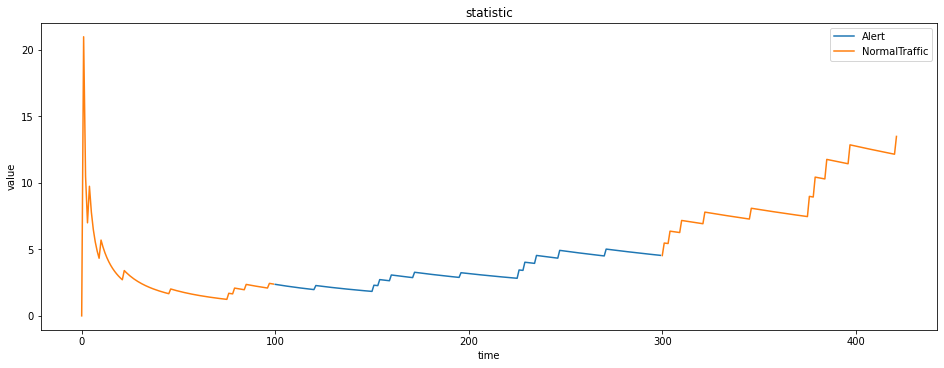

In [83]:
fig, ax = plt.subplots(figsize=(13,5), layout='constrained')
#ax.plot(time, trafficMean, label='TrafficMean')
#ax.plot(time, dVar, label='Dvar')
alertTimeList = np.arange(100, 300)
alertTime = np.ma.masked_where(np.isin(time, alertTimeList, invert=True), time)
normalTime = np.ma.masked_where(np.isin(time, alertTimeList, invert=False), time)
ax.plot(alertTime, traffic, label='Alert')
ax.plot(normalTime, traffic, label='NormalTraffic')
ax.legend()
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('value')  # Add a y-label to the axes.
ax.set_title("statistic")

In [80]:
print(time.all() not in alertTimeList)

True


In [71]:
print(normalTime)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

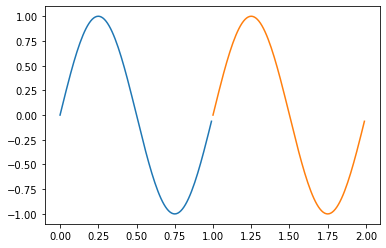

In [78]:
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2 * np.pi * t)

t1 = np.ma.masked_where(t >= 1, t)
t2 = np.ma.masked_where(t < 1, t)
print(t >= 1)
fig, ax = plt.subplots()
ax.plot(t1, s, t2, s)
plt.show()